# Linear models last time step prediction

In [63]:
import matplotlib.pyplot as plt
import json
import os
import datetime
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
data_dir = './vaccine_data/hhs_data/'

In [64]:
def convert_to_calender_data(week_offset_from_aug_1,year):
    '''Returns the calender Week'''
    d = "{}-W{}".format(year,week_offset_from_aug_1+31)
    r = datetime.datetime.strptime(d + '-0', "%Y-W%W-%w")
    r = r.strftime("%B %d, %Y")    
    return r

In [65]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

In [66]:
train_years = ['2013','2014']
dev_years = ['2015']
test_years = ['2016','2017']

train_download_dir = ('train',train_years)
dev_download_dir = ('dev',dev_years)
test_download_dir = ('test',test_years)
data_split_ls = [train_download_dir,dev_download_dir,test_download_dir]

# States 

In [71]:
## Plotting Year count trends year on year dev

def predict_state(state,threshold_start_pred):
    ### Plottting Code
    fig=plt.figure( dpi= 100)
    for data_split in data_split_ls:
        split,years = data_split
        for year in years:
            data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
            data['percentage']=data['percentage']
            # data = data[['week','count','percentage','disparity','week_start']]
            count_vaccinated_week = (data['percentage']*data['count']).values
            count_vaccinated_week[1:]=count_vaccinated_week[1:]- count_vaccinated_week[0:-1]
            count_vaccinated_week[0]=0
            plt.plot(data['week'],count_vaccinated_week,label=state+"_"+year);
            print("Max Week => week_num {}, Date = {}".format(count_vaccinated_week.argmax(),convert_to_calender_data(count_vaccinated_week.argmax(),year)))
    plt.grid()     
    plt.xlabel('Weeks, starting from aug-1')
    plt.ylabel('People Vaccinated')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    ### Model Train Code

    split,years = train_download_dir
    Y = []
    X = []
    for year in years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
        percent_vaccinated_week = (data['percentage']).values
        percent_vaccinated_week = percent_vaccinated_week -  week_means

        initial_week_vals = [percent_vaccinated_week[i] for i in range(0,threshold_start_pred)]

        for i in range(threshold_start_pred,len(percent_vaccinated_week)):
            X.append([i]+initial_week_vals)
            Y.append(percent_vaccinated_week[i])


    X = np.asarray(X)
    Y = np.asarray(Y)
    model = linear_model.LinearRegression()
    model.fit(X,Y)
    y_pred = model.predict(X)
    error = metrics.mean_squared_error([y_pred[-1]],[Y[-1]])
    print("Error in last train prediction {} %".format(error*100 ))

    ## Dev Prediction

    split = 'dev'
    year = '2015'
    data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
    percent_vaccinated_week = (data['percentage']).values
    percent_vaccinated_week = percent_vaccinated_week -  week_means

    initial_week_vals = [percent_vaccinated_week[i] for i in range(0,threshold_start_pred)]
    Y = []
    X = []
    for i in range(threshold_start_pred,len(percent_vaccinated_week)):
        X.append([i]+initial_week_vals)
        Y.append(percent_vaccinated_week[i])

    X = np.asarray(X)
    Y = np.asarray(Y)

    y_pred = model.predict(X)
    error = metrics.mean_squared_error([y_pred[-1]],[Y[-1]])
    print("State: {} Error in last dev prediction {} %".format(state, error*100 ))

    ## Test Prediction

    split = 'test'
    years = ['2016','2017']
    for year in years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
        percent_vaccinated_week = (data['percentage']).values
        percent_vaccinated_week = percent_vaccinated_week -  week_means[0:len(percent_vaccinated_week)]

        initial_week_vals = [percent_vaccinated_week[i] for i in range(0,threshold_start_pred)]
        Y = []
        X = []
        for i in range(threshold_start_pred,len(percent_vaccinated_week)):
            X.append([i]+initial_week_vals)
            Y.append(percent_vaccinated_week[i])

        X = np.asarray(X)
        Y = np.asarray(Y)
        y_pred = model.predict(X)
        error = metrics.mean_squared_error([y_pred[-1]],[Y[-1]])
        print("State: {} Error in last test prediction {} %".format(state, error*100 ))

    print("State:{} Model Coeff {},".format(state,model.coef_))



In [72]:
states = ['WA','AK','CO','CT','NJ','MT']


----------
State = WA
----------


TypeError: predict_state() missing 1 required positional argument: 'threshold_start_pred'

----------
State = WA With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 9, Date = October 12, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


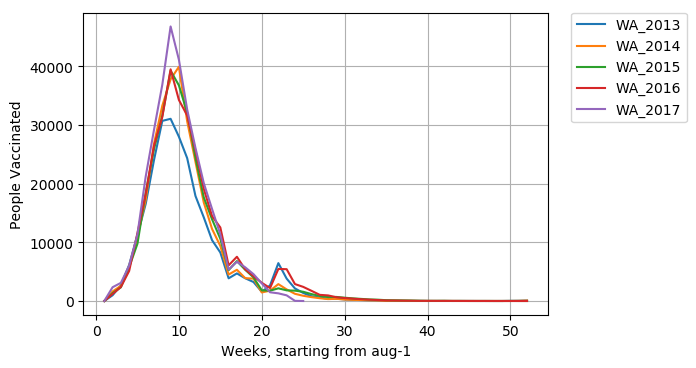

Error in last train prediction 3.5969306137066984e-05 %
State: WA Error in last dev prediction 0.001530628250257724 %
State: WA Error in last test prediction 0.005679247330621583 %
State: WA Error in last test prediction 0.045534910670835954 %
State:WA Model Coeff [-9.14826531e-07  1.17488030e+00  2.17611874e+00  1.35392456e+00],
----------
State = AK With first 3 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 7, Date = September 28, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 9, Date = October 08, 2017


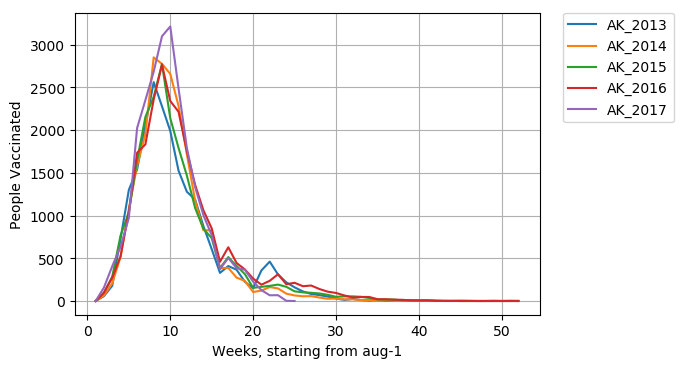

Error in last train prediction 0.04169837679019427 %
State: AK Error in last dev prediction 0.018375246511246987 %
State: AK Error in last test prediction 0.059319961925413306 %
State: AK Error in last test prediction 0.0004179429529780202 %
State:AK Model Coeff [-1.59806730e-03 -6.39667537e+00 -6.78079983e+00 -1.07207411e+01],
----------
State = CO With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


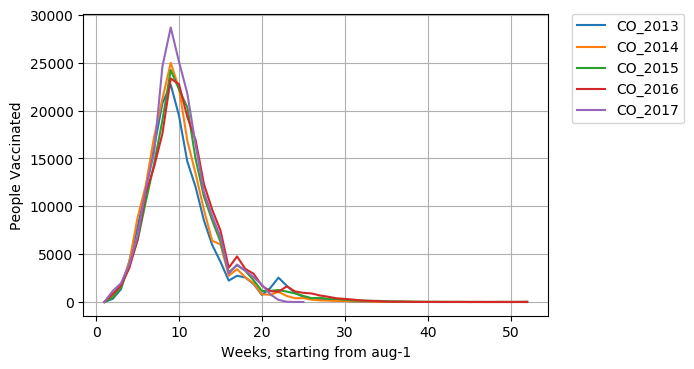

Error in last train prediction 0.0012952623841665596 %
State: CO Error in last dev prediction 0.04404333139326478 %
State: CO Error in last test prediction 0.021664254704370247 %
State: CO Error in last test prediction 0.0922414975431628 %
State:CO Model Coeff [ 1.06187240e-04 -1.45009134e-01 -3.06899200e-01 -4.67074973e-01],
----------
State = CT With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 10, Date = October 15, 2017


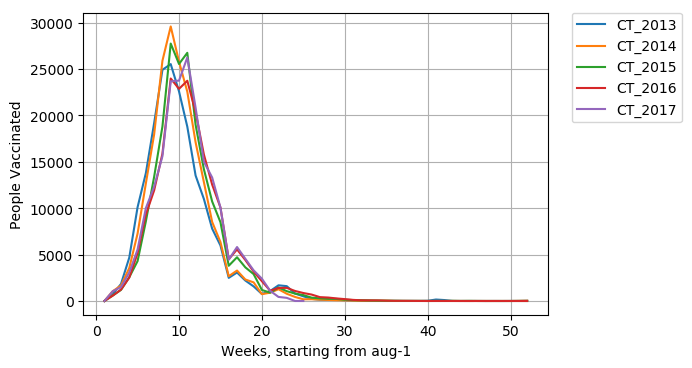

Error in last train prediction 0.015898824380422383 %
State: CT Error in last dev prediction 0.07647823804259546 %
State: CT Error in last test prediction 0.07793784583828635 %
State: CT Error in last test prediction 0.05343895280509372 %
State:CT Model Coeff [0.00084903 0.02093446 0.04072215 0.02211008],
----------
State = NJ With first 3 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


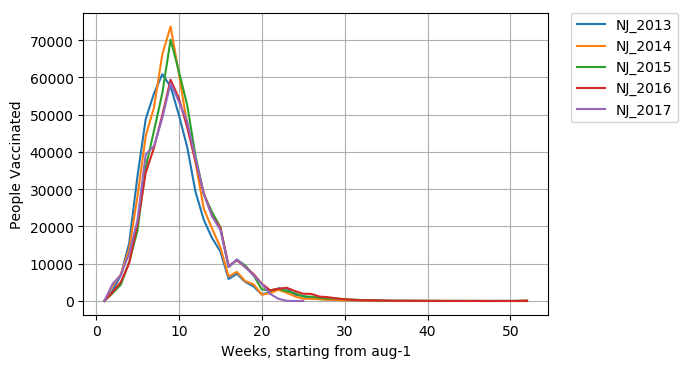

Error in last train prediction 4.41794293494715e-05 %
State: NJ Error in last dev prediction 0.03207525656393626 %
State: NJ Error in last test prediction 0.040209326088797126 %
State: NJ Error in last test prediction 0.2060661089060781 %
State:NJ Model Coeff [-7.89231531e-05  1.60396081e-01  2.65559972e-01  2.36799778e-01],
----------
State = MT With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


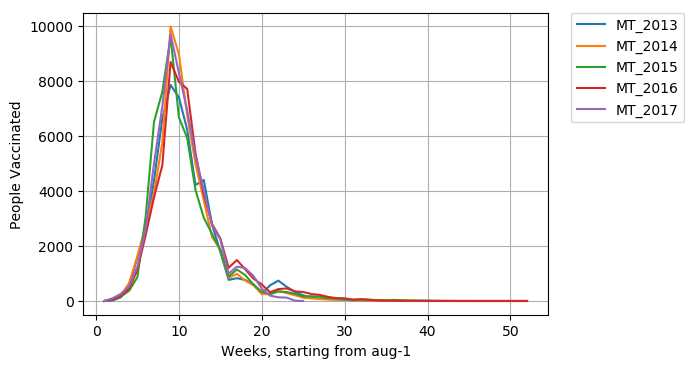

Error in last train prediction 0.0002470275557333313 %
State: MT Error in last dev prediction 0.018442510137022985 %
State: MT Error in last test prediction 0.0071510361295866595 %
State: MT Error in last test prediction 0.06766024277315207 %
State:MT Model Coeff [-2.83296752e-04 -7.59434050e-01 -2.10840965e+00 -3.47718054e+00],


In [75]:
start_week = 3
for state in states:
    print("-"*10)
    print("State = {} With first {} weeks".format(state,start_week))
    print("-"*10)
    predict_state(state,start_week)

# First 4 weeks

----------
State = WA With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 9, Date = October 12, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


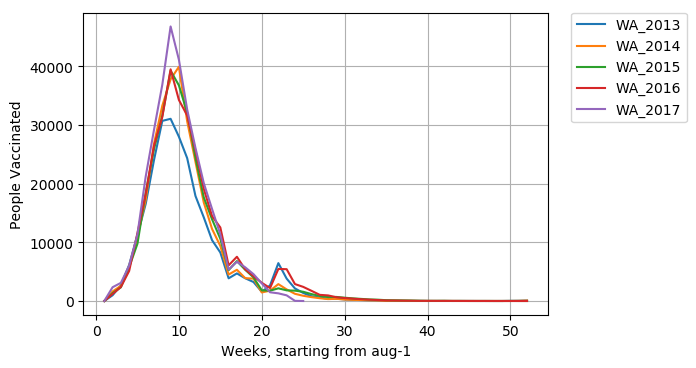

Error in last train prediction 0.00023547424441664301 %
State: WA Error in last dev prediction 0.004080705046846087 %
State: WA Error in last test prediction 0.0015202695555954343 %
State: WA Error in last test prediction 0.04406869103253201 %
State:WA Model Coeff [ 5.39591457e-05  1.14225421e+00  2.11568854e+00  1.31632646e+00
 -6.23379139e-01],
----------
State = AK With first 4 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 7, Date = September 28, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 9, Date = October 08, 2017


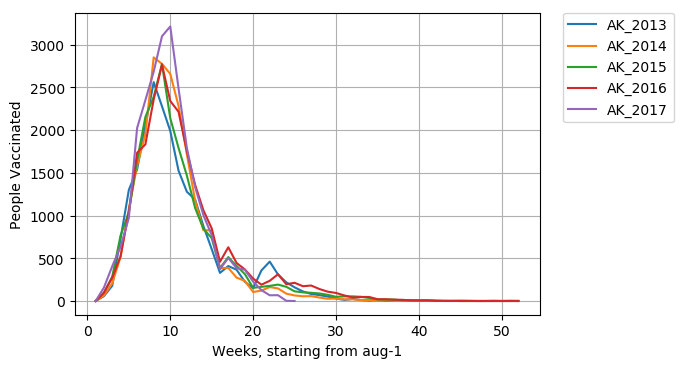

Error in last train prediction 0.02983223981756587 %
State: AK Error in last dev prediction 0.03186207208360625 %
State: AK Error in last test prediction 0.00537519401277708 %
State: AK Error in last test prediction 0.2741490930638617 %
State:AK Model Coeff [-1.39349865e-03 -1.74164227e-01 -1.84622901e-01 -2.91896881e-01
  2.32630871e+00],
----------
State = CO With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


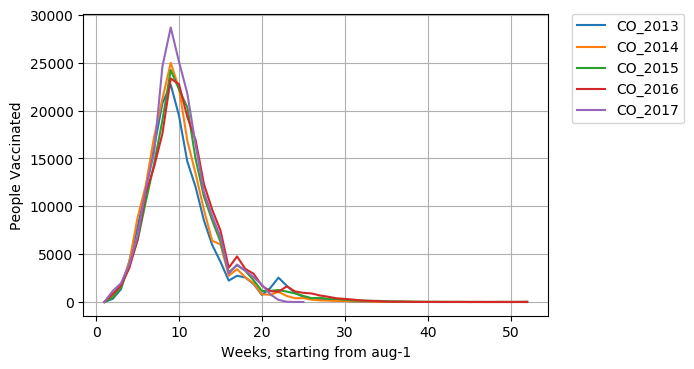

Error in last train prediction 0.001014530768513573 %
State: CO Error in last dev prediction 0.04493322007265186 %
State: CO Error in last test prediction 0.022322031229027175 %
State: CO Error in last test prediction 0.0966305041762001 %
State:CO Model Coeff [ 8.18684026e-05 -1.29056398e-01 -2.73136623e-01 -4.15691148e-01
 -2.07723864e-01],
----------
State = CT With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 10, Date = October 15, 2017


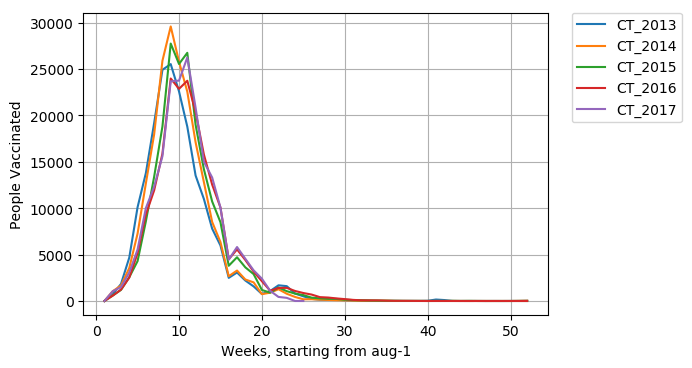

Error in last train prediction 0.011654526990502543 %
State: CT Error in last dev prediction 0.06840647406928115 %
State: CT Error in last test prediction 0.06984831209113977 %
State: CT Error in last test prediction 0.06042598167822388 %
State:CT Model Coeff [ 0.00073127  0.01083859  0.02108346  0.01144726 -0.03837968],
----------
State = NJ With first 4 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


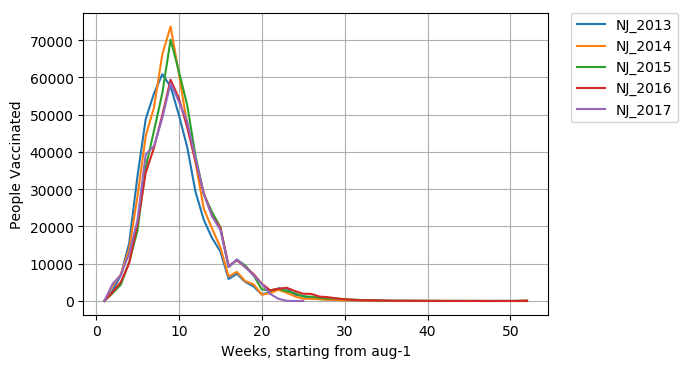

Error in last train prediction 0.00043601286727710717 %
State: NJ Error in last dev prediction 0.028364045635360425 %
State: NJ Error in last test prediction 0.035841284685570955 %
State: NJ Error in last test prediction 0.21622586145451528 %
State:NJ Model Coeff [-1.71049753e-04  1.62968531e-01  2.69819053e-01  2.40597599e-01
 -3.95824810e-02],
----------
State = MT With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


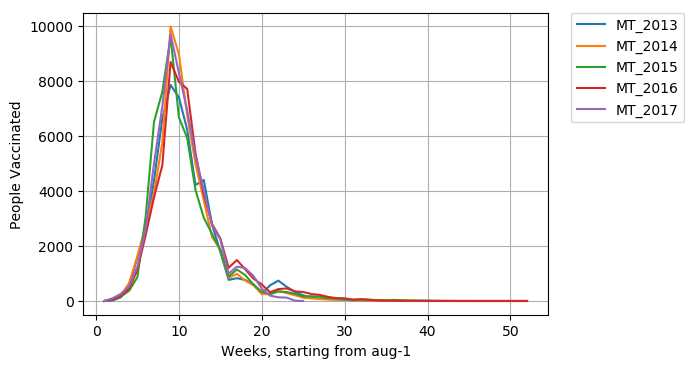

Error in last train prediction 5.9752060976973186e-06 %
State: MT Error in last dev prediction 0.03592561437337615 %
State: MT Error in last test prediction 0.016855587416621336 %
State: MT Error in last test prediction 0.07742087423021571 %
State:MT Model Coeff [-1.94592228e-04 -2.98636644e-01 -8.29102120e-01 -1.36735181e+00
 -2.06552500e+00],


In [76]:
start_week = 4
for state in states:
    print("-"*10)
    print("State = {} With first {} weeks".format(state,start_week))
    print("-"*10)
    predict_state(state,start_week)